# Install and Set Up Kaggle and API Key

Follow these steps to install and configure the Kaggle API on your system:

1. **Create a Kaggle Account**
   - Visit [Kaggle](https://www.kaggle.com) and sign up for an account.

2. **Obtain Kaggle API Key**
   - Go to your Kaggle account settings.
   - Find the "API" section and click on "Create New API Token".
   - This will download a `kaggle.json` file containing your API key.

3. **Install Kaggle Package**
   - Use Conda to install the Kaggle package by running:
     ```bash
     conda install kaggle
     ```

4. **Configure API Key**
   - Copy the `kaggle.json` file to your user directory under the `.kaggle` folder. On most systems, you can use the following command:
     ```bash
     mkdir -p ~/.kaggle
     cp path_to_downloaded_kaggle.json ~/.kaggle/kaggle.json
     chmod 600 ~/.kaggle/kaggle.json
     ```
   - Ensure the `.kaggle` directory and the `kaggle.json` file have the proper permissions by setting:
     ```bash
     chmod 600 ~/.kaggle/kaggle.json
     ```


In [1]:
import pandas as pd
import kaggle
import Marketing_Campaign as mc
# Pre processing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import numpy as np


# Scoring 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline as make_imbalance_pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Import Dataset

In [2]:
# Get the data using an API call
kaggle.api.dataset_download_files('rodsaldanha/arketing-campaign', path='resources', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign


In [3]:
# Import the data
data = pd.read_csv("./resources/marketing_campaign.csv",delimiter=';')


# EDA (Exploratory Data Analysis)
We will revisit this. For now We want the rough draft of the model
#
During EDA

Visualize the data using plots and graphs to understand distributions and relationships between variables.
Calculate summary statistics to get a sense of the central tendencies and variability.
Identify any correlations between variables that might influence model choices.
Detect and treat missing values or outliers that could skew the results of your analysis.
Explore the data's structure to inform feature selection and engineering, which are key to building effective machine learning models.

# Read any and all documentation you can find on your dataset to understand it better


In [4]:
display (data.head())
# what does our data look like? At this point also use any documentation on the data set to find out what each value means and how it might be used is solving the business problem
print (f'{data.shape}\n')
print (data.columns)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


(2240, 29)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


# We are going through 5 steps to clean the dataset
- data1: Autodrop NA when the na % is less than 2% 
- data2: drop columns with only on value
- data3: Drop highly corrilated feature
- data4: Encode education
- data5: Set Generation from birth year
- data6: Convert dt_customer from date to lenght in months
- data7: Replace outliers with Single
- data8: One Hot Encode Marital Status and Education
- data9: Drop ID and Year Birth
- data10: Drop low corrilations 


In [5]:
# data1: Autodrop NA when the na % is less than 2% 
# Preprocess = Clean up NA if number of NA in column is less that a percentage of rows
# this automatically cleans up rows below a threshold and list columns when NA rows exceed the threshold

data1=mc.auto_drop_na(data,2)


Drop Percent of the rows is %2
If the number of NA values in a column is less than the calculated threshold, automatically drop the NA rows.
{'Income': 24}
Automatically dropping rows in Income where NA values are present.


In [6]:
# data2: drop columns with only on value
# # identify columns that have a single value
# Find columns with only one unique value
single_value_columns = [col for col in data1.columns if data1[col].nunique() == 1]

# Optionally, display the unique value for each of those columns
for col in single_value_columns:
    print(f"Column {col} has the unique value: {data1[col].unique()[0]}")
# Print columns with only one unique value
print (f'Columns with a single unique value: {single_value_columns} DROPPED')
# test dropping some columns
data2 =data1.drop(single_value_columns, axis=1)

Column Z_CostContact has the unique value: 3
Column Z_Revenue has the unique value: 11
Columns with a single unique value: ['Z_CostContact', 'Z_Revenue'] DROPPED


In [7]:
# Identify non numeric columns we will need to deal with
non_numeric= (data2.dtypes[(data2.dtypes != 'int64') & (data2.dtypes != 'float64')]).index.tolist()
# display (data.dtypes)
print (f'Columns that are not numeric :\n {non_numeric}\n')

for column in non_numeric:
    print (data2[column].value_counts())
    print ('\n')

Columns that are not numeric :
 ['Education', 'Marital_Status', 'Dt_Customer']

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


Dt_Customer
2012-08-31    12
2012-09-12    11
2013-02-14    11
2014-05-12    11
2013-08-20    10
              ..
2012-08-05     1
2012-11-18     1
2014-05-09     1
2013-06-26     1
2014-01-09     1
Name: count, Length: 662, dtype: int64




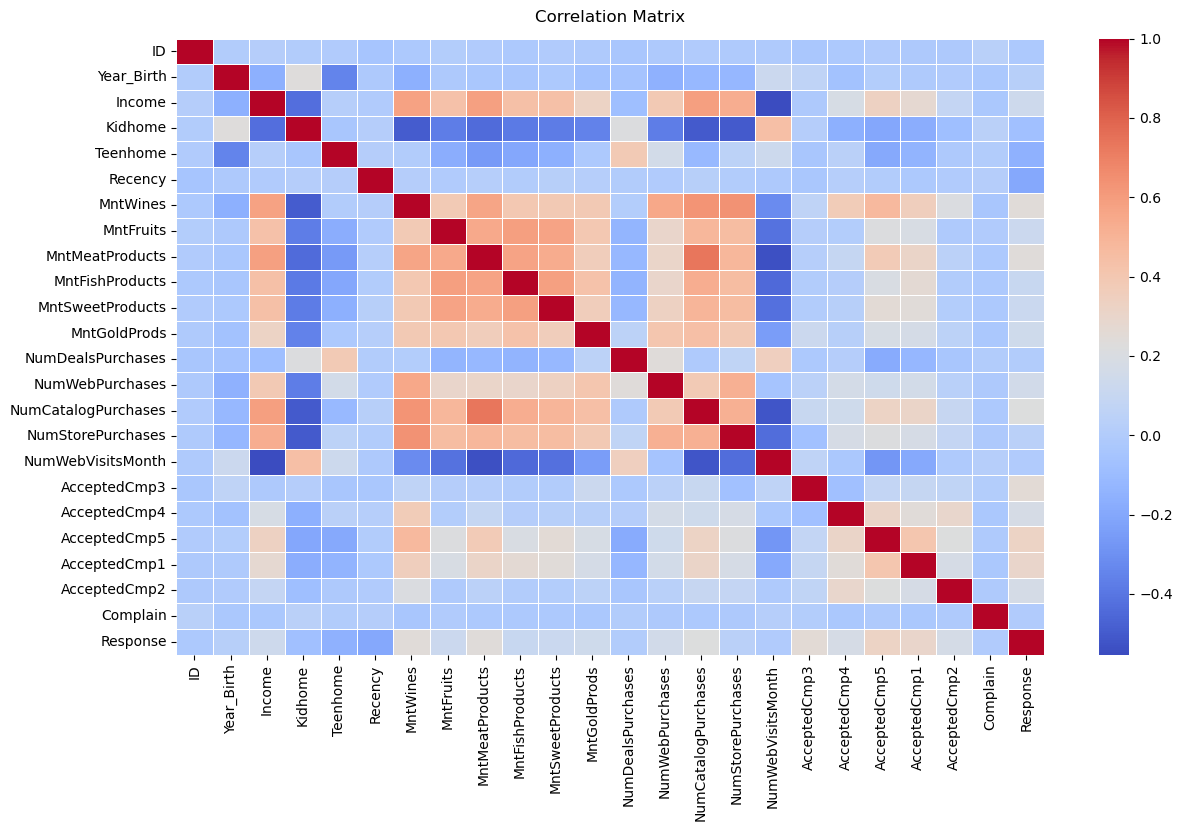

In [8]:
coor1=data2.drop(non_numeric,axis=1)
correlation_matrix = coor1.corr()
# display (correlation_matrix)
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, fmt=".2f")
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()



## Correlation Matrix Heatmap Analysis

The heatmap analysis reveals the relationships between various variables in the dataset. Below is a structured breakdown of these relationships, providing insights into customer behaviors and preferences.

### Strong Positive Correlations

- **MntWines and NumCatalogPurchases**: 
  - A strong positive correlation suggests that customers who spend more on wines also tend to make more catalog purchases.
- **MntWines and MntMeatProducts**: 
  - Customers who spend more on wines also tend to spend more on meat products.
- **NumCatalogPurchases and NumWebPurchases**: 
  - This correlation indicates that customers who purchase more through catalogs also tend to purchase more through the web.

### Strong Negative Correlations

- **NumWebVisitsMonth and NumCatalogPurchases**: 
  - A strong negative correlation implies that customers who visit the website more frequently tend to make fewer catalog purchases.
- **NumWebVisitsMonth and NumStorePurchases**: 
  - More web visits are associated with fewer in-store purchases.

### Interesting Insights

- **Income**: 
  - Positively correlated with spending on wines, meat, and sweet products, suggesting higher income leads to higher spending on these items.
- **NumWebVisitsMonth**: 
  - Negatively correlated with several purchase types, indicating that frequent web visitors may be just browsing rather than purchasing.
- **Campaign Acceptance**: 
  - Analyzing correlations between different campaign acceptance variables (e.g., AcceptedCmp1, AcceptedCmp2, etc.) can help identify how different campaigns are related or if accepting one campaign predicts accepting another.

### Neutral or Weak Correlations

- Many pairs of variables show weak or no significant correlation (closer to 0), indicating limited linear relationship between those variables.

### Example Specific Pairs

- **AcceptedCmp4 and AcceptedCmp1**: 
  - There is a visible correlation that suggests customers who accepted Campaign 1 are also likely to accept Campaign 4.
- **Z_Revenue**: 
  - Correlation with other spending-related variables indicates how total revenue might relate to specific purchase categories.

### Interpretation for Analysis

- **Marketing Strategy**:
  - Understand customer segments that prefer catalog purchases vs. web purchases.
  - Tailor campaigns based on correlated product purchases.
- **Customer Profiling**:
  - Target high-income customers for premium products like wines and meat.
- **Web Behavior**:
  - High web traffic doesn't necessarily convert to purchases, suggesting a need for strategies to improve web conversion rates.


In [9]:
# I want to create a lsit of coor values from the report and drop them. For now manual drop is ok

# test dropping some columns
data3 =data2.drop(['MntMeatProducts', 'NumCatalogPurchases', 'NumWebPurchases','NumStorePurchases'], axis=1)
# data3 =data2.drop(['MntWines' , 'NumWebPurchases'], axis=1)

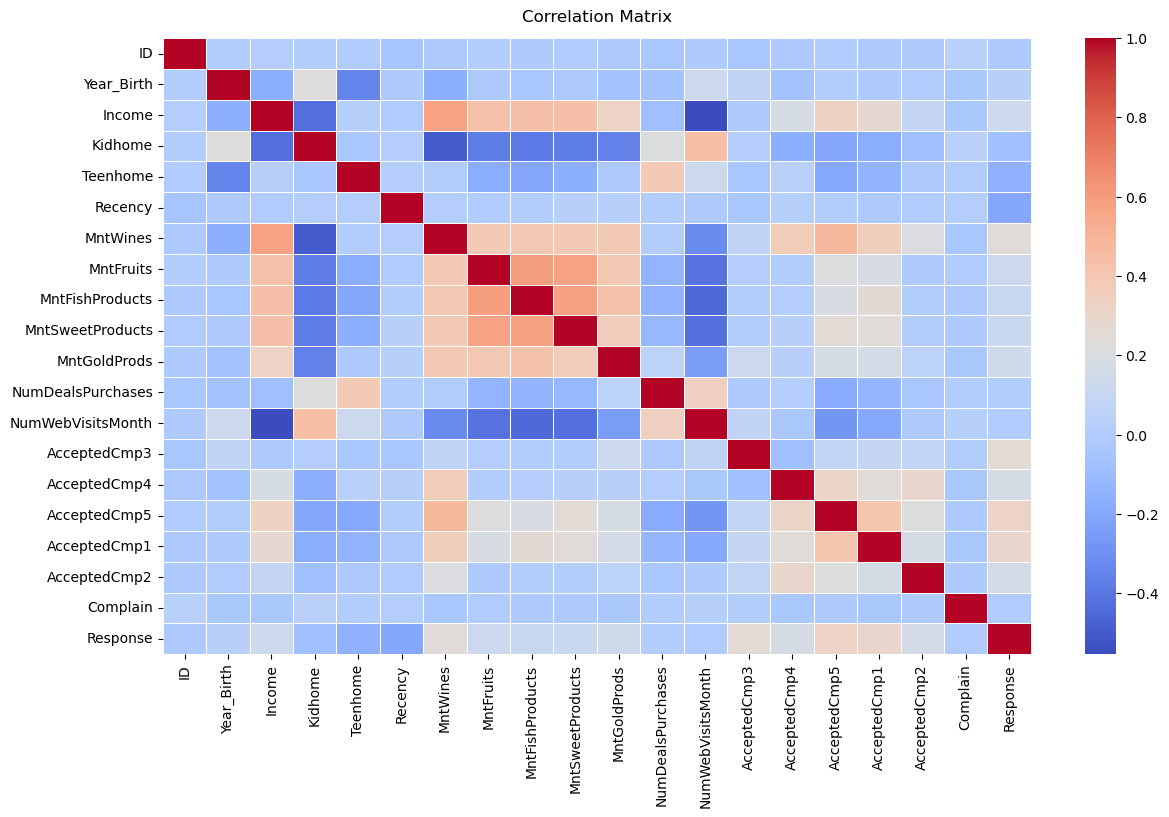

In [10]:
coor1=data3.drop(non_numeric,axis=1)
correlation_matrix = coor1.corr()
# display (correlation_matrix)
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, fmt=".2f")
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()


# Numeric data to group
The year of birth data creates too many unique data to be useful. We have chosen to convert the Year Birth data to a 6 generation values. After one hot encode for generation we drop the year birth column. 

# non numeric column 
- Education OrdinalEncoder because education counts
     - 0 - **Basic** This generally refers to elementary or primary education.
     - 1 - **2n Cycle** This is not a commonly used term globally but might refer to secondary education or an intermediary level in some education systems.
     - 2 - **Graduation** Typically refers to the completion of a bachelor's or undergraduate degree.
     - 3 - **Master** A postgraduate degree that follows the completion of a bachelor's degree.
     - 4 - **PhD** The highest university degree, typically following a master's degree.

- Marital_Status - The status has no weighted values. change none standard answers to single and then one hot encode three remaining values
     - Alone     Single
     - Absurd    Single
     - YOLO      Single

- Year_Birth - Convert to 6 generations and then One Hot Encode

- Dt_Customer - We will convert to data time and represent this in number of months the cusomter has been with us

# ID column
The id column is etiher a uniwue customer id or an index falue that became a column in the past

In [11]:
# data4: Encode education
# 
categories = ['Basic','2n Cycle','Graduation','Master','PhD']
column = 'Education'
data4 = mc.preprocess_ord(data3,column,categories)

# One Hot Encode
We want to One Hot Encode Marital Status and Generations.
This takes some preperation
-- Marital needs to change Alone, Absurd and YOLO to Single. 
-- Year_Birth needs to be encoded as generations first

In [12]:
# data5: Set Generation from birth year
data5 = mc.set_gen(data4,'Year_Birth')

# data6: Convert dt_customer from date to lenght in months
data6 = mc.date_to_months(data5,'Dt_Customer',2024)

# data7 - Replace erronious with Single
data6['Marital_Status']= data6['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
data7 = data6

# data8: One Hot Encode Marital Status and Education
ohe_column_list = ['Marital_Status', 'Generations']
data8 = mc.preprocess_ohe(data7,ohe_column_list)

# data9: Drop ID and Year Birth
data9 = data8.drop(['ID','Year_Birth'],axis=1)


In [13]:
# Pick a y column
y_value='Response'

# Evaluating Corrilation and Imbalance

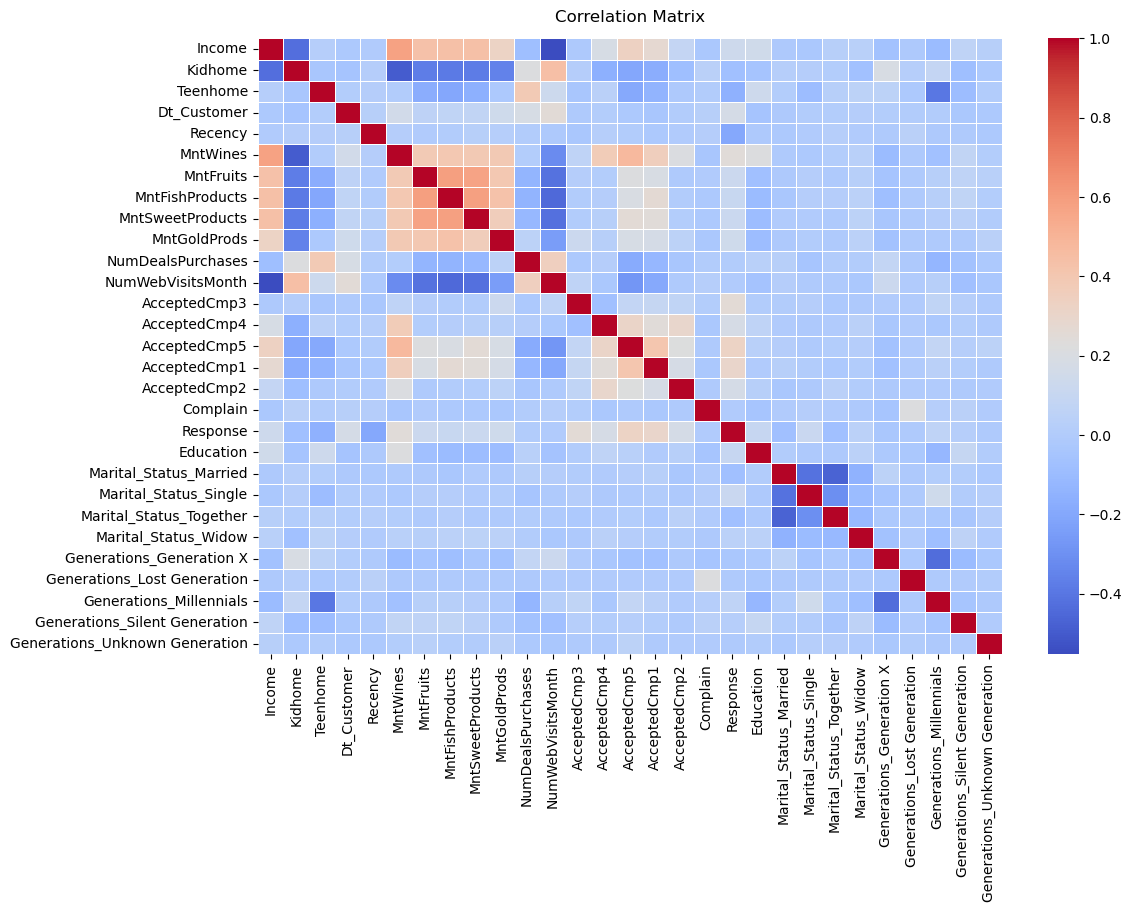

In [14]:

correlation_matrix = data9.corr()

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, fmt=".2f")
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()


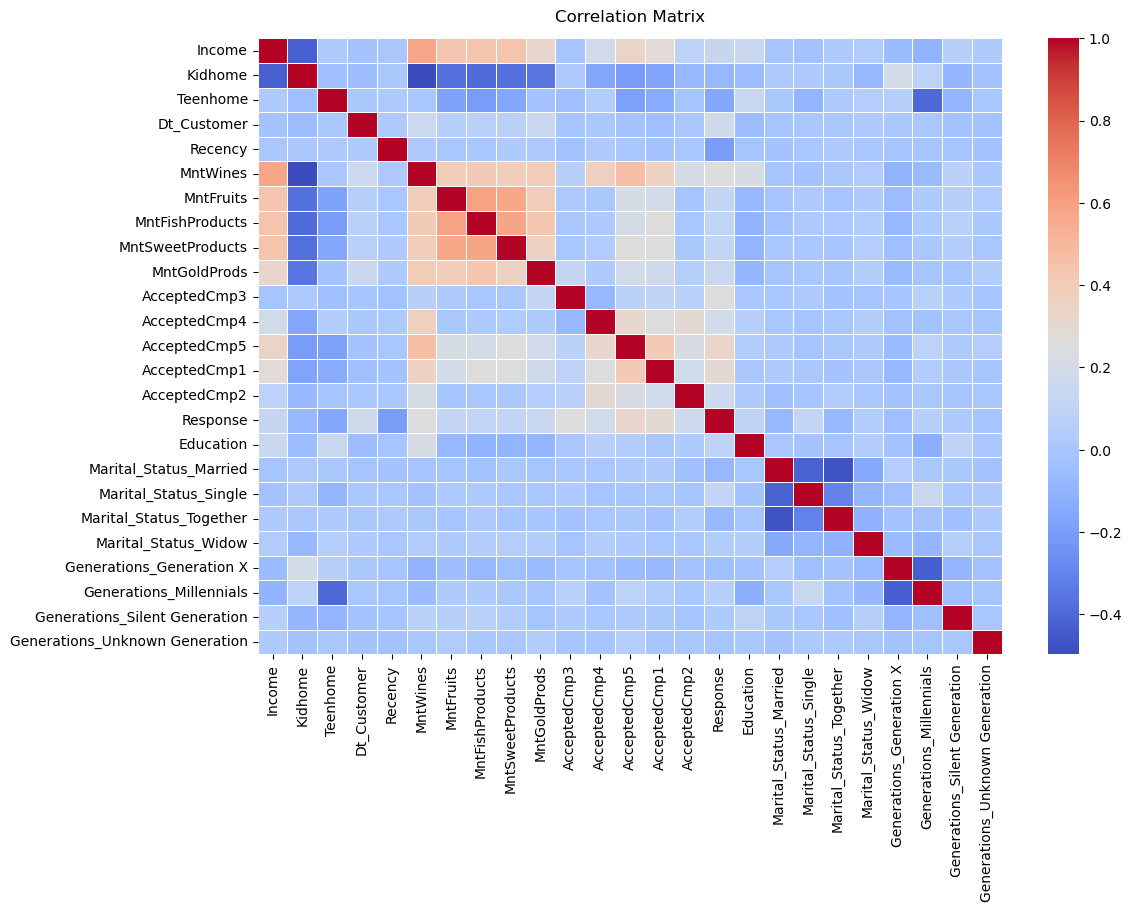

In [15]:
# data10 - Drop low corrilations 
# Compute the correlation with the target variable 'Y'
correlation_with_y = data9.corr()[y_value].drop(y_value)  # Drop the self-correlation of 'Y'

# Identify features with correlation less than 0.01 in absolute terms
low_correlation_features = correlation_with_y[abs(correlation_with_y) < 0.01].index

# Drop these features from the DataFrame
data10 = data9.drop(columns=low_correlation_features)

# Print the remaining columns in the DataFrame
correlation_matrix = data10.corr()

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, fmt=".2f",)
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [16]:
# Set X and y
X=data10.drop([y_value],axis=1)
y=data10[y_value]



In [17]:

# Checking the distribution of classes
class_distribution = y.value_counts()
print(class_distribution)
# Getting the percentage distribution of the classes
class_percentage = y.value_counts(normalize=True) * 100
print(class_percentage)

Response
0    1883
1     333
Name: count, dtype: int64
Response
0    84.972924
1    15.027076
Name: proportion, dtype: float64


# Our data is very imbalanced. 
## we will addess imbalancing in the modeling pipeline

In [18]:

X=data10.drop([y_value],axis=1)
y=data10[y_value]

In [19]:
#  Identify features with less that 1% importance and drop them
#  
model = RandomForestClassifier(n_estimators=60,random_state=42)
model.fit(X, y)

# Get feature importances and create a mask for dropping features
importances = model.feature_importances_
features_to_drop = importances < 0.01
# Drop features from DataFrame
X_reduced = X.loc[:, ~features_to_drop]

print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {X_reduced.shape[1]}")
X=X_reduced

Original number of features: 24
Reduced number of features: 21


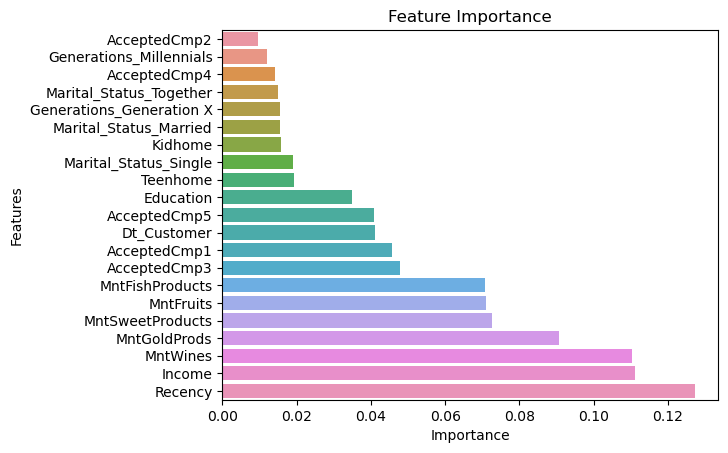

In [20]:
model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_

# Create a Series for easier plotting
feature_importance = pd.Series(importances, index=X.columns)

# Sorting importances
sorted_importances = feature_importance.sort_values()

# Creating a bar plot
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

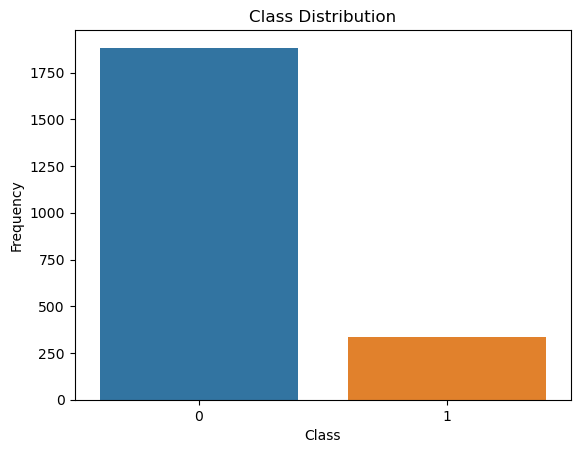

In [21]:
# Plotting the distribution of classes
sns.countplot(x=data6[y_value])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# life is balance in the fast lane

Using 

classification report for
- dataset with no changes
- dataset with underfit RandomUnderSampler
- dataset with overfit RandomOverSampler
- dataset with smote SMOTE
- dataset with smoteenn SMOTEENN

Scalers
- StandardScaler
- MinMaxScaler

Model
- RANDOM FOREST MODEL
- GradientBoostingClassifier
- KNeighborsClassifier
- SVM (Support Vector Machine)
- LogisticRegression
- Decision Tree Model


# Repeated Stratified K-Fold Cross-Validation 
Repeated Stratified K-Fold Cross-Validation Example
This project demonstrates the use of RepeatedStratifiedKFold from the scikit-learn library for evaluating a model's performance using cross-validation. This method is particularly useful for datasets with imbalanced classes and provides a more stable estimate of model accuracy by repeating the stratified cross-validation multiple times.

Overview
RepeatedStratifiedKFold extends the StratifiedKFold approach by repeating the stratified fold process multiple times, which helps in achieving a more generalized and robust model evaluation. It ensures that each class is evenly represented in each fold and reduces variance associated with a single trial of cross-validation.

Requirements
Python 3.8+
scikit-learn
Installation
To install the required packages, use the following pip command:

bash
Copy code
pip install scikit-learn
Usage
Run the model_evaluation.py script to evaluate the model using RepeatedStratifiedKFold cross-validation:

bash
Copy code
python model_evaluation.py
Example Code
Here is the example code that uses RepeatedStratifiedKFold with the SVM classifier on the Iris dataset:

python
Copy code
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define model
model = SVC()

# Setup cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Evaluate model
scores = cross_val_score(model, X, y, cv=cv)

print("Mean Accuracy: %0.2f" % scores.mean())
This script loads the Iris dataset, initializes an SVM classifier, and evaluates it using repeated stratified K-fold cross-validation. The results display the mean accuracy across all folds and repeats.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Step 3: Scale the data (after resampling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Transform test data based on training scaler


In [23]:

# List of classifiers
classifiers = [
    ('RFC', RandomForestClassifier(random_state=42)),
    ('GBC', GradientBoostingClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC(random_state=42)),
    ('LR',  LogisticRegression()),
    ('DTC', DecisionTreeClassifier(random_state=42)),
    ('KMeans', KMeans())
]

# List of scalers
scalers = [
    ('SS', StandardScaler()),
    ('MMS', MinMaxScaler())
]

# List of resampling methods
samplers = [
    ('RUS', RandomUnderSampler(random_state=42)),
    ('ROS', RandomOverSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
    ('SMOTEENN', SMOTEENN(random_state=42)),
    ('ADASYN' , ADASYN(random_state=42))
]

# Evaluating each combination of sampler, scaler, and classifier
results = []

# Run just the classifier
for classifier_name, classifier in classifiers:
    pipeline = make_imbalance_pipeline(classifier)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(('NA','NA',classifier_name, scores.mean()))

# Run Scaler and Classifier
for scaler_name, scaler in scalers:
    for classifier_name, classifier in classifiers:
        pipeline = make_imbalance_pipeline(scaler, classifier)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        results.append(('NA', scaler_name, classifier_name, scores.mean()))

# Run Sampler and Classifier
for sampler_name, sampler in samplers:
    for classifier_name, classifier in classifiers:
        pipeline = make_imbalance_pipeline(sampler, classifier)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        results.append((sampler_name, 'NA', classifier_name, scores.mean()))

# Run Sampler, Scaler and Classifier
for sampler_name, sampler in samplers:
    for scaler_name, scaler in scalers:
        for classifier_name, classifier in classifiers:
            pipeline = make_imbalance_pipeline(sampler, scaler, classifier)
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
            scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
            results.append((sampler_name, scaler_name, classifier_name, scores.mean()))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Sampler', 'Scaler', 'Classifier', 'Accuracy'])
sorted_results_df = results_df.sort_values(by='Accuracy', ascending=False)
print (f'The top 5 models by are:\n')
print (sorted_results_df.head(15).to_string(index=False))


The top 5 models by are:

Sampler Scaler Classifier  Accuracy
     NA    MMS         LR  0.890860
     NA     SS         LR  0.887024
     NA    MMS        GBC  0.881831
     NA     NA        GBC  0.881774
     NA     SS        GBC  0.881718
     NA     SS        RFC  0.880136
     NA     NA        RFC  0.879967
     NA    MMS        RFC  0.879911
     NA    MMS        SVC  0.879797
     NA     SS        SVC  0.878162
    ROS    MMS        RFC  0.875905
    ROS     NA        RFC  0.875848
    ROS     SS        RFC  0.875680
  SMOTE    MMS        GBC  0.869250
  SMOTE     SS        GBC  0.869080


# n_estimator
Using Cross Val Score We found that an N_estimator value of 105 would optimize our Random Forest Classifier

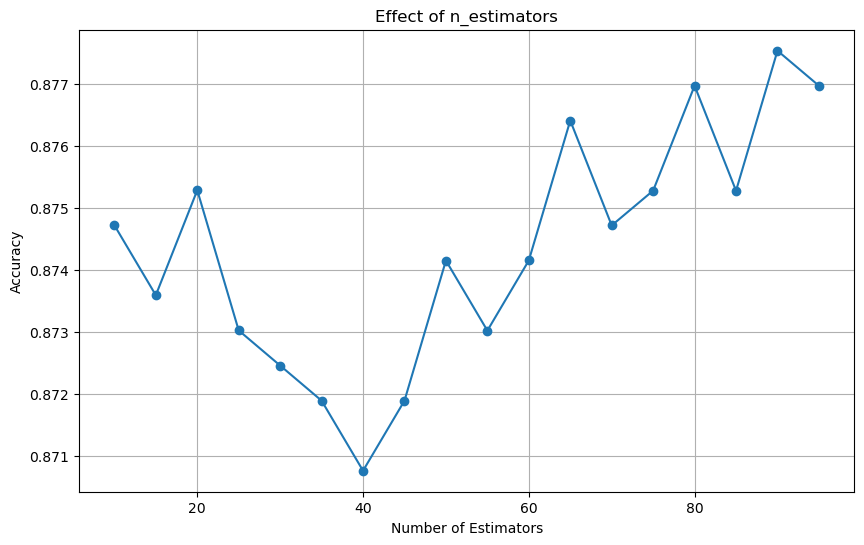

In [24]:
# Using the top model by accuracy score fid the best n_estimator
scores = []
estimators_range = range(10, 100, 5)  # From 10 to 300 in steps of 20

for n in estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    scores.append(np.mean(score))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Effect of n_estimators')
plt.grid(True)
plt.show()

In [25]:
# Rate each features importance
model = RandomForestClassifier(n_estimators=90,random_state=42)
model.fit(X_train_scaled, y_train)  # Ensure X and y are your feature matrix and target vector respectively
importance = model.feature_importances_

# Correct printing method
for i, v in enumerate(importance):
    print('Feature: %d, Score: %.5f' % (i, v))

from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10)
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"\n{X_train.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

Feature: 0, Score: 0.11013
Feature: 1, Score: 0.01290
Feature: 2, Score: 0.01851
Feature: 3, Score: 0.04477
Feature: 4, Score: 0.11462
Feature: 5, Score: 0.09992
Feature: 6, Score: 0.07291
Feature: 7, Score: 0.07553
Feature: 8, Score: 0.07276
Feature: 9, Score: 0.08598
Feature: 10, Score: 0.05327
Feature: 11, Score: 0.01423
Feature: 12, Score: 0.05308
Feature: 13, Score: 0.04728
Feature: 14, Score: 0.01056
Feature: 15, Score: 0.03358
Feature: 16, Score: 0.01698
Feature: 17, Score: 0.01984
Feature: 18, Score: 0.01605
Feature: 19, Score: 0.01515
Feature: 20, Score: 0.01196

Recency: 0.018 +/- 0.006

AcceptedCmp1: 0.014 +/- 0.005

MntSweetProducts: 0.011 +/- 0.004

AcceptedCmp5: 0.009 +/- 0.003

MntFishProducts: 0.009 +/- 0.003

Marital_Status_Single: 0.008 +/- 0.003

AcceptedCmp3: 0.008 +/- 0.004

MntWines: 0.007 +/- 0.002

Kidhome: 0.004 +/- 0.002


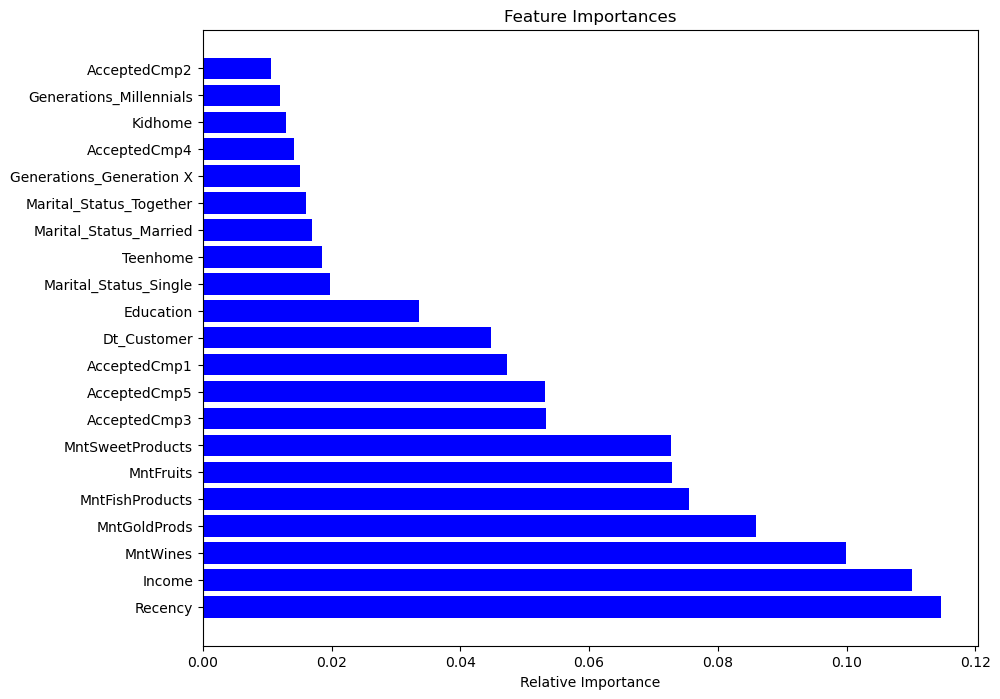

In [26]:
# Extract feature importances and sort them
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns  # Assuming your training data is a DataFrame

# Create a plot
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Applying PCA on Training Data
When using PCA (Principal Component Analysis) in a machine learning workflow, it's crucial to apply the PCA only to the training data (X_train). This approach prevents data leakage and ensures the integrity of model validation.

Why Use X_train Only
Prevent Data Leakage: By fitting PCA on X_train, you avoid using any knowledge from the test set (X_test) during model training. This maintains the validity of your model evaluation because the test set should mimic completely new, unseen data.

Maintain Validation Integrity: Transformations like PCA should only utilize historical (training) data to simulate a real-world scenario where only past information is available for decision-making.

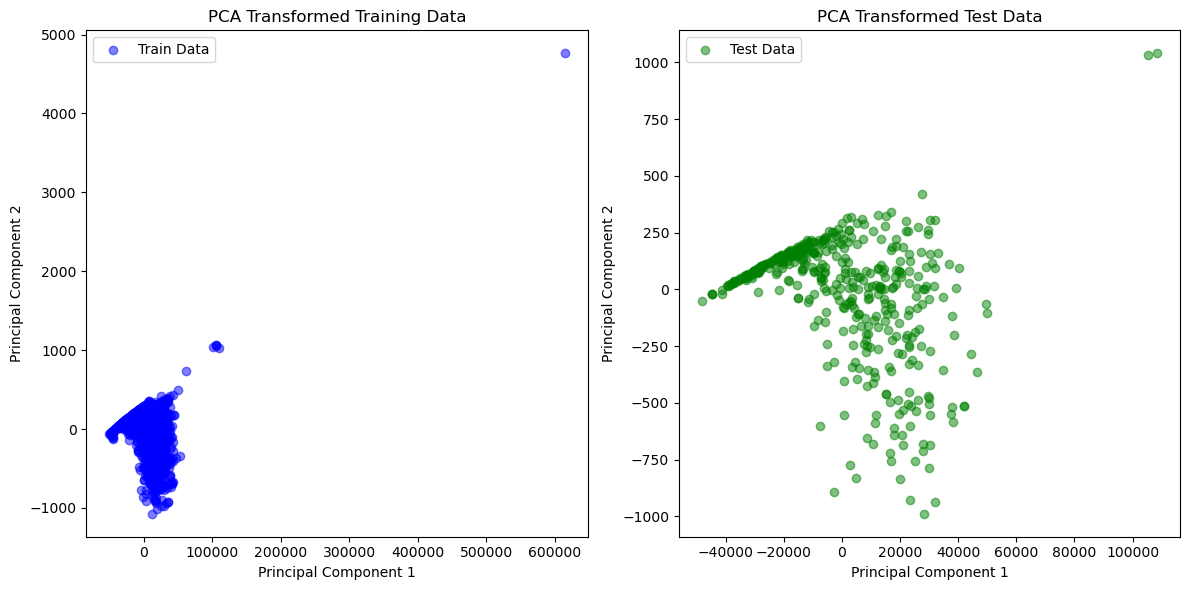

In [27]:
# Initialize PCA with 10 components and fit on the training data
pca_model = PCA(n_components=10).fit(X_train)

# Transform the training and testing data using the fitted PCA
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

# Convert transformed arrays to DataFrame for better handling and visualization
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Display the first few rows of the transformed data
# print("PCA Transformed Training Data:")
# print(X_train_pca_df.head())
# print("PCA Transformed Test Data:")
# print(X_test_pca_df.head())

mc.plot_pca_results(X_train_pca_df, X_test_pca_df)

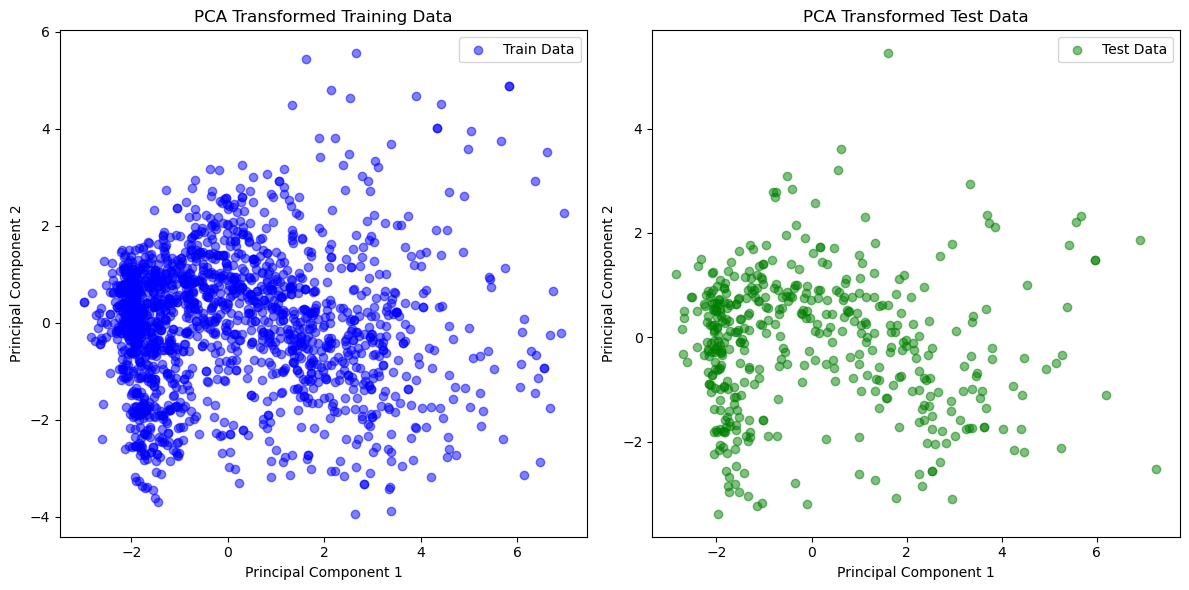

In [28]:
# Initialize PCA with 10 components and fit on the training data
pca_model = PCA(n_components=10).fit(X_train_scaled)

# Transform the training and testing data using the fitted PCA
X_train_pca = pca_model.transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

# Convert transformed arrays to DataFrame for better handling and visualization
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Display the first few rows of the transformed data
# print("PCA Transformed Training Data:")
# print(X_train_pca_df.head())
# print("PCA Transformed Test Data:")
# print(X_test_pca_df.head())

mc.plot_pca_results(X_train_pca_df, X_test_pca_df)

In [29]:

# Train and evaluate the model
# model = RandomForestClassifier(n_estimators=80, random_state=42)
# model.fit(X_train_scaled, y_train_resampled)  # Use the scaled and resampled training data
#y_pred = model.predict(X_test_scaled)  # Predict using the scaled test data
# print(classification_report(y_test, y_pred))

# no sampling or scaling
# Train and evaluate the model
model = RandomForestClassifier(n_estimators=80, random_state=42)
model.fit(X_train, y_train)  # Use the scaled and resampled training data
y_pred = model.predict(X_test)  # Predict using the scaled test data
print ('PreProcessed no Sampler, Scaler or PCA')
print(classification_report(y_test, y_pred))

PreProcessed no Sampler, Scaler or PCA
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       382
           1       0.64      0.34      0.44        62

    accuracy                           0.88       444
   macro avg       0.77      0.65      0.69       444
weighted avg       0.86      0.88      0.86       444



In [30]:

# Train and evaluate the model
# model = RandomForestClassifier(n_estimators=80, random_state=42)
# model.fit(X_train_scaled, y_train_resampled)  # Use the scaled and resampled training data
#y_pred = model.predict(X_test_scaled)  # Predict using the scaled test data
# print(classification_report(y_test, y_pred))

# no sampling or scaling
# Train and evaluate the model
model = RandomForestClassifier(n_estimators=90, random_state=42)
model.fit(X_train_scaled, y_train)  # Use the scaled and resampled training data
y_pred_mm_scaler = model.predict(X_test_scaled)  # Predict using the scaled test data
print ('PreProcessed with Scaler no Sampler or PCA')
print(classification_report(y_test, y_pred_mm_scaler))

PreProcessed with Scaler no Sampler or PCA
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       382
           1       0.66      0.34      0.45        62

    accuracy                           0.88       444
   macro avg       0.78      0.65      0.69       444
weighted avg       0.87      0.88      0.87       444



In [31]:

# Train and evaluate the model
# model = RandomForestClassifier(n_estimators=80, random_state=42)
# model.fit(X_train_scaled, y_train_resampled)  # Use the scaled and resampled training data
#y_pred = model.predict(X_test_scaled)  # Predict using the scaled test data
# print(classification_report(y_test, y_pred))

# no sampling or scaling
# Train and evaluate the model
model = RandomForestClassifier(n_estimators=90, random_state=42)
model.fit(X_train_pca_df, y_train)  # Use the scaled and resampled training data
y_pred_pca = model.predict(X_test_pca_df)  # Predict using the scaled test data
print ('PreProcessed Sampler no Scaler or PCA')
print(classification_report(y_test, y_pred_pca))

PreProcessed Sampler no Scaler or PCA
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       382
           1       0.70      0.37      0.48        62

    accuracy                           0.89       444
   macro avg       0.80      0.67      0.71       444
weighted avg       0.88      0.89      0.87       444



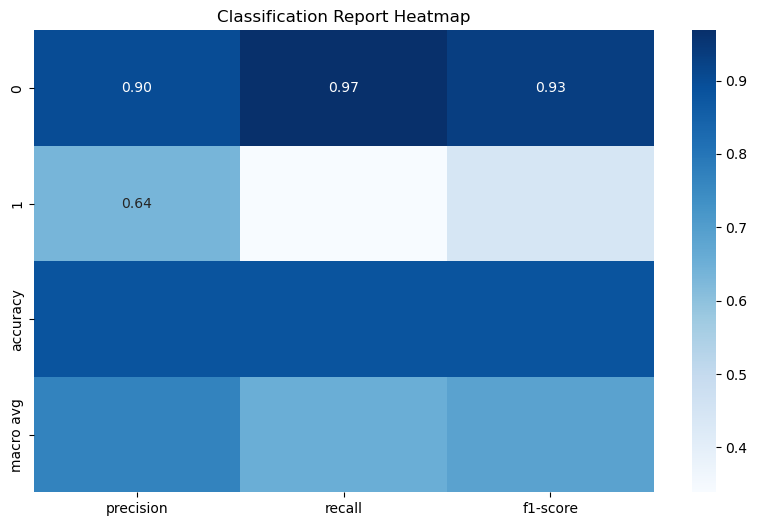

In [32]:

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].drop(columns='support'), annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap')
plt.show()


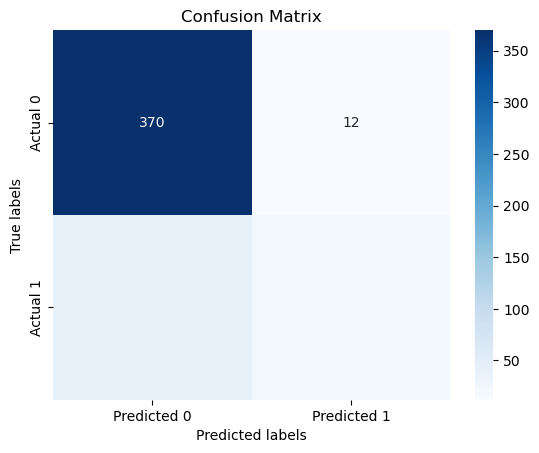

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


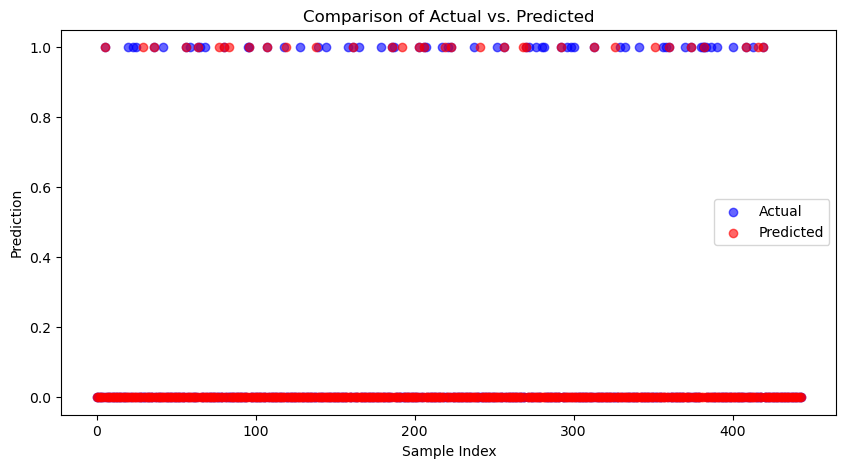

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.6)
plt.title('Comparison of Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.legend()
plt.show()


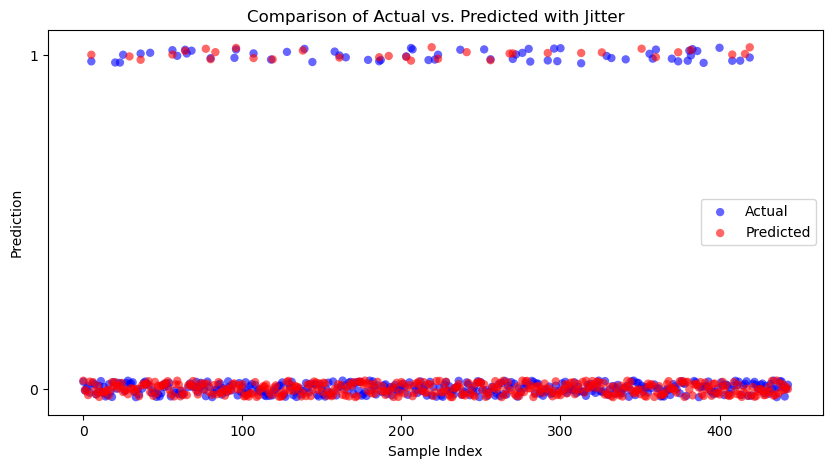

In [35]:
# Adding a small amount of random noise to the y-values
jitter_y_test = y_test + 0.05 * np.random.rand(len(y_test)) - 0.025
jitter_y_pred = y_pred + 0.05 * np.random.rand(len(y_pred)) - 0.025

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), jitter_y_test, color='blue', label='Actual', alpha=0.6, edgecolor='none')
plt.scatter(range(len(y_pred)), jitter_y_pred, color='red', label='Predicted', alpha=0.6, edgecolor='none')
plt.title('Comparison of Actual vs. Predicted with Jitter')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.yticks([0, 1])
plt.legend()
plt.show()

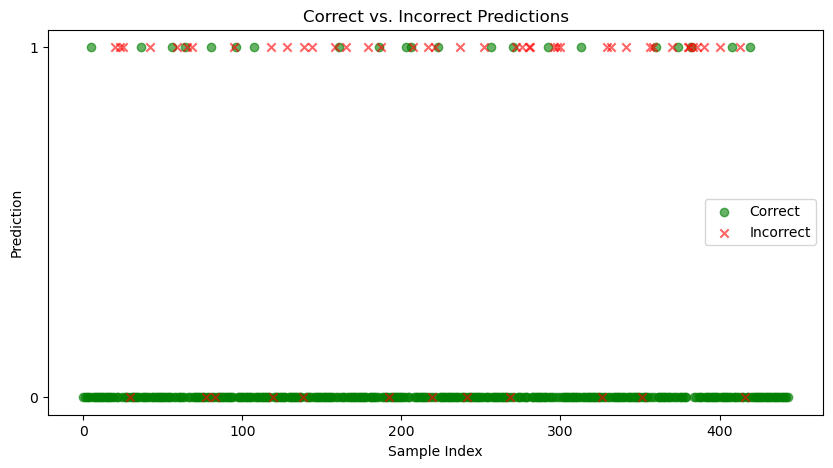

In [36]:
# Determine correct and incorrect predictions
correct = y_test == y_pred
incorrect = ~correct

plt.figure(figsize=(10, 5))
# Correct predictions
plt.scatter(np.where(correct)[0], y_test[correct], color='green', marker='o', label='Correct', alpha=0.6)
# Incorrect predictions
plt.scatter(np.where(incorrect)[0], y_test[incorrect], color='red', marker='x', label='Incorrect', alpha=0.6)
plt.title('Correct vs. Incorrect Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.yticks([0, 1])
plt.legend()
plt.show()


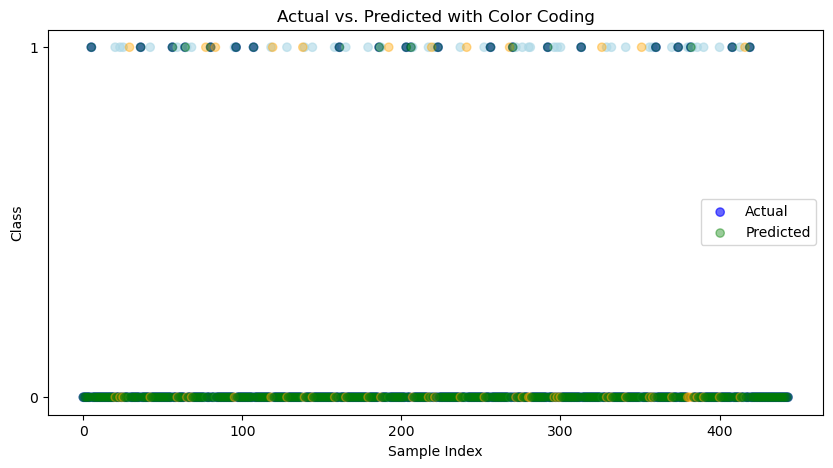

In [37]:
plt.figure(figsize=(10, 5))
# Plotting actual values
plt.scatter(range(len(y_test)), y_test, c=['blue' if x else 'lightblue' for x in correct], label='Actual', alpha=0.6)
# Plotting predicted values
plt.scatter(range(len(y_pred)), y_pred, c=['green' if x else 'orange' for x in correct], label='Predicted', alpha=0.4)
plt.title('Actual vs. Predicted with Color Coding')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.yticks([0, 1])
plt.legend()
plt.show()


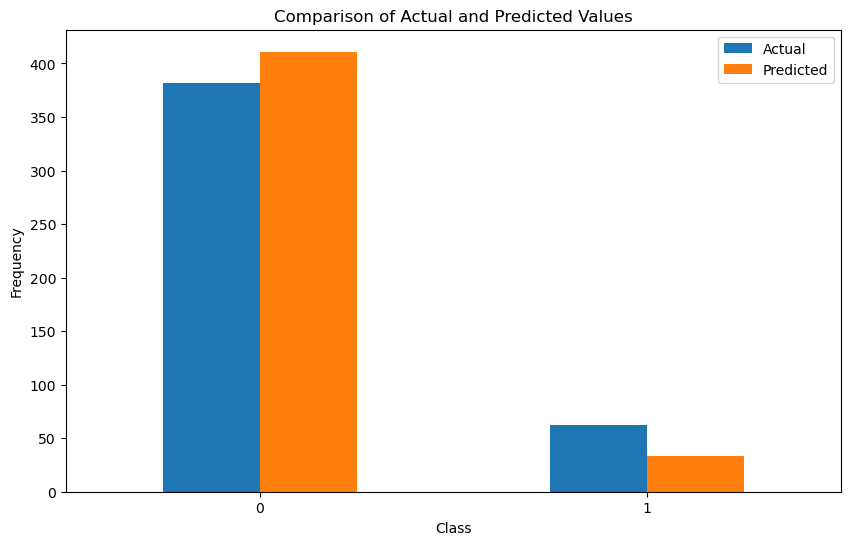

In [38]:
# Assuming y_test and y_pred are your actual and predicted values respectively
df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Count frequencies of each class
comparison_counts = df_comparison.apply(pd.Series.value_counts)

# Create a bar plot
comparison_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [39]:
# Predict probabilities for the test data
y_probs = model.predict_proba(X_test_pca)[:, 1]  # probabilities for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, marker='.', label='Random Forest Classifier (AUC = %0.2f)' % roc_auc_score(y_test, y_probs))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

c:\Users\gefhz\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 21 features, but RandomForestClassifier is expecting 10 features as input.

In [ ]:
# Predict probabilities for the test data
y_probs = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, marker='.', label='Random Forest Classifier (AUC = %0.2f)' % roc_auc_score(y_test, y_probs))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()